<a href="https://colab.research.google.com/github/rhrokib/bangla_vulgarity_detection/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np 
import pandas as pd

#Dataset

In [2]:
from sklearn.model_selection import train_test_split
df = pd.read_csv('data/preprocessed_dataset.csv', na_values='nan')
df.drop(columns=['Unnamed: 0'], inplace=True)
df = df[:100]

train_data, test_data = train_test_split(df, random_state=7654, stratify=df['target'])

#testing models

In [3]:
training_sentences = []
testing_sentences = []
training_labels = train_data['target']
testing_labels = test_data['target']

for t in train_data['text']:
  training_sentences.append(str(t))

for t in test_data['text']:
  testing_sentences.append(str(t))

In [4]:
testing_labels = np.array(testing_labels)
training_labels = np.array(training_labels)

#Hyper Perameters

In [46]:
num_epochs = 3
vocab_size = 8000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'


#Tokenizing and Padding sentences

In [47]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, truncating=trunc_type)\

#Updating vocab_size
# vocab_size = len(word_index) if len(word_index) < 5000 else 5000

#Experimenting with different models

In [48]:
my_models = {}

#Model Double_Layer_LSTM

Model: "Double_Layer_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Padded_data (Embedding)     (None, 120, 16)           128000    
                                                                 
 Bidirectional_1 (Bidirectio  (None, 120, 64)          12544     
 nal)                                                            
                                                                 
 Bidirectional_2 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 Dense_6 (Dense)             (None, 6)                 198       
                                                                 
 Dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 151,117
Trainable params: 151,117
N

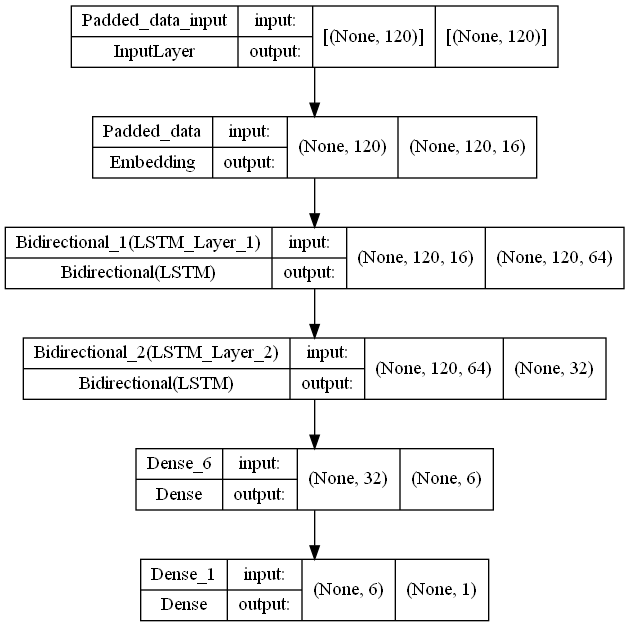

In [59]:
from tensorflow.keras.utils import plot_model

model  = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, name='Padded_data'),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim*2, name='LSTM_Layer_1', return_sequences=True), name='Bidirectional_1'),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, name='LSTM_Layer_2'), name='Bidirectional_2'),
  tf.keras.layers.Dense(6, activation='relu', name='Dense_6'),
  tf.keras.layers.Dense(1, activation='sigmoid', name='Dense_1')
], name='Double_Layer_LSTM')

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
plot_model(model, to_file=f'Figures/models/{model.name}.png', show_shapes=True, show_layer_names=True)

In [60]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()
history = model.fit(padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)
my_models[model.name] = model

Epoch 1/3
3/3 [==============================] - 2s 787ms/step - loss: 0.6876 - accuracy: 0.8400 - val_loss: 0.6725 - val_accuracy: 1.0000
Epoch 2/3
3/3 [==============================] - 2s 619ms/step - loss: 0.6677 - accuracy: 1.0000 - val_loss: 0.6494 - val_accuracy: 1.0000
Epoch 3/3
3/3 [==============================] - 2s 624ms/step - loss: 0.6399 - accuracy: 1.0000 - val_loss: 0.6120 - val_accuracy: 1.0000


In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(name, history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.title(name, bbox=dict(facecolor='white', alpha=0))
  plt.savefig(f'Figures/metric/{name}_{string}.png', dpi=300, transparent=False)
  plt.show()
  
plot_graphs(model.name, history, "accuracy",)
plot_graphs(model.name, history, "loss")

#Model Single Layer LSTM

Model: "Single_layer_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Padded_data (Embedding)     (None, 120, 16)           128000    
                                                                 
 Bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 Dense_6 (Dense)             (None, 6)                 390       
                                                                 
 Dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 140,941
Trainable params: 140,941
Non-trainable params: 0
_________________________________________________________________


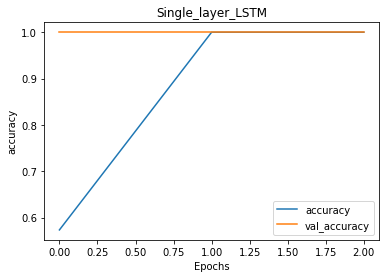

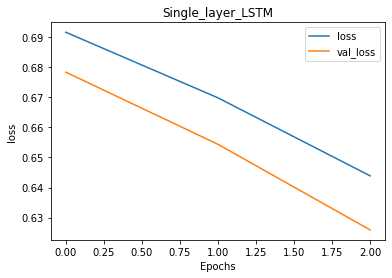

<Figure size 432x288 with 0 Axes>

In [52]:
model  = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, name='Padded_data'),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim*2, name='LSTM_Layer'), name='Bidirectional'), #LSTM1
  tf.keras.layers.Dense(6, activation='relu', name='Dense_6'),
  tf.keras.layers.Dense(1, activation='sigmoid', name='Dense_1')
], name='Single_layer_LSTM')

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
plot_model(model, to_file=f'Figures/models/{model.name}.png', show_shapes=True, show_layer_names=True)

history = model.fit(padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=0)
my_models[model.name] = model

plot_graphs(model.name, history, "accuracy",)
plot_graphs(model.name, history, "loss")

#Model GRU_LSTM

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Padded_data (Embedding)     (None, 120, 16)           128000    
                                                                 
 Bidirectional (Bidirectiona  (None, 64)               9600      
 l)                                                              
                                                                 
 Dense_6 (Dense)             (None, 6)                 390       
                                                                 
 Dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 137,997
Trainable params: 137,997
Non-trainable params: 0
_________________________________________________________________


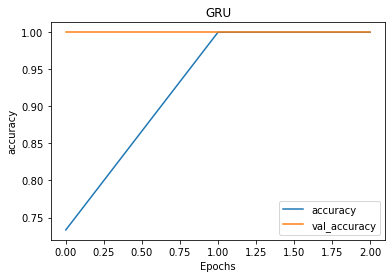

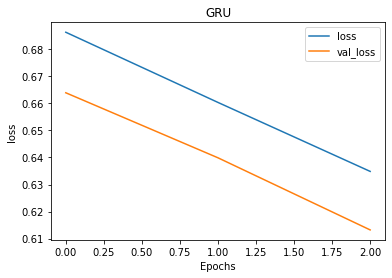

<Figure size 432x288 with 0 Axes>

In [58]:
model  = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, name='Padded_data'),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(embedding_dim*2, name='GRU_Layer'), name='Bidirectional'), #LSTM1
  tf.keras.layers.Dense(6, activation='relu', name='Dense_6'),
  tf.keras.layers.Dense(1, activation='sigmoid', name='Dense_1')
], name='GRU')

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
plot_model(model, to_file=f'Figures/models/{model.name}.png', show_shapes=True, show_layer_names=True)

history = model.fit(padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=0)
my_models[model.name] = model

plot_graphs(model.name, history, "accuracy",)
plot_graphs(model.name, history, "loss")

# Model CNN Convo1D

Model: "Convo1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Padded_data (Embedding)     (None, 120, 16)           128000    
                                                                 
 Conv1D_Layer (Conv1D)       (None, 116, 128)          10368     
                                                                 
 Flattening_Layer (GlobalAve  (None, 128)              0         
 ragePooling1D)                                                  
                                                                 
 Dense_6 (Dense)             (None, 6)                 774       
                                                                 
 Dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 139,149
Trainable params: 139,149
Non-trainable params: 0
_____________________________________________________

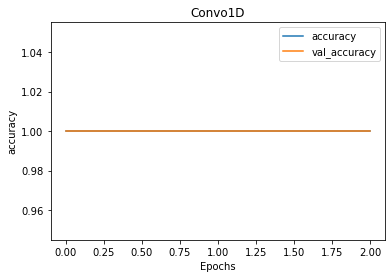

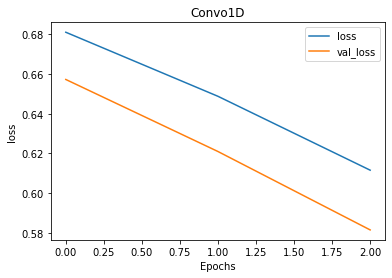

<Figure size 432x288 with 0 Axes>

In [57]:
model  = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, name='Padded_data'),
  # tf.keras.layers.Bidirectional(tf.keras.layers.GRU(embedding_dim*2, name='GRU_Layer'), name='Bidirectional'), #LSTM1
  tf.keras.layers.Conv1D(128, 5, activation='relu', name='Conv1D_Layer'),
  tf.keras.layers.GlobalAveragePooling1D(name='Flattening_Layer'),
  tf.keras.layers.Dense(6, activation='relu', name='Dense_6'),
  tf.keras.layers.Dense(1, activation='sigmoid', name='Dense_1')
], name='Convo1D')

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
plot_model(model, to_file=f'Figures/models/{model.name}.png', show_shapes=True, show_layer_names=True)

history = model.fit(padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=0)
my_models[model.name] = model

plot_graphs(model.name, history, "accuracy",)
plot_graphs(model.name, history, "loss")

#Embedding Vector

In [36]:
# reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# def decode_review(text):
#     return ' '.join([reverse_word_index.get(i, '?') for i in text])


# e = model.layers[0]
# weights = e.get_weights()[0]

# #To save the embedding vector_meta
# import io

# def save_vector(vocab_size, reverse_word_index, weights):
#     out_v = io.open('/content/drive/MyDrive/Colab Notebooks/thesis_project/vectors/vecs.tsv', 'w', encoding='utf-8')
#     out_m = io.open('/content/drive/MyDrive/Colab Notebooks/thesis_project/vectors/meta.tsv', 'w', encoding='utf-8')
#     for word_num in range(1, vocab_size):
#         word = reverse_word_index[word_num]
#         embeddings = weights[word_num]
#         out_m.write(word + "\n")
#         out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
#     out_v.close()
#     out_m.close()
        
        
# save_vector(vocab_size, reverse_word_index, weights)

# try:
#   from google.colab import files
# except ImportError:
#   pass
# else:
#   files.download('vecs.tsv')
#   files.download('meta.tsv')

In [35]:
# pred = (model.predict(testing_padded) > 0.5).astype(int)

#Testing with manual input

In [37]:
# sen = ['এত্তগুলা গালি 😑', 'কুত্তার বাচ্চা', 'কি আর লিখবো! মান সন্মান নিয়ে প্রশ্ন']

# test_sequences = tokenizer.texts_to_sequences(sen)
# test_padded = pad_sequences(test_sequences, maxlen=max_length, truncating=trunc_type)

# print(model.predict(test_padded)) 

[[0.75189924]
 [0.7555782 ]
 [0.74018055]]


#Saving a model

In [38]:
# model.save('saved_models/LSTM_BI2.h5')

#Loading a pre-saved model

In [39]:
# new_model = tf.keras.models.load_model('saved_models/LSTM_BI2.h5')